# Demo on running the ground failure models and output figures manually

## Preconditions
* We assume you are using the default model and mapping config files included in the groundfailure repository [here](https://github.com/usgs/groundfailure/tree/master/defaultconfigfiles)
* To run the models you need to have the model_inputs folder containing all the global input files on your local system (currently 80 GB)
* For static mapping, you need to have the mapping_inputs folder containing all the global input files on your local system (currently 10 GB)
* You must have the groundfailure codes and their dependencies installed and in your path (see [groundfailure readme] (https://github.com/usgs/groundfailure/) on how to do this)

## First, we'll manually run the models and plotting functions
*Note that all file paths are local to Kate's file system and these will need to be updated if you want to run this notebook*

### Import modules


In [1]:
#stdlib imports
from configobj import ConfigObj
import os

#local imports
from groundfailure.newmark import godt2008
from groundfailure.logisticmodel import LogisticModel
from groundfailure.conf import correct_config_filepaths
from groundfailure.makemaps import parseConfigLayers, parseMapConfig
from groundfailure import makemaps

%matplotlib inline

### Set up file paths that will be used

In [2]:
homedir = os.path.join(os.path.expanduser('~'), 'SecondaryHazards') 

# Directory containing model inputs
datadir = os.path.join(homedir, 'Codes/model_inputs')

# Path to config files
configfileG = os.path.join(homedir, 'Codes/groundfailure/defaultconfigfiles/models/godt_2008.ini')
configfileN = os.path.join(homedir, 'Codes/groundfailure/defaultconfigfiles/models/nowicki_2014_global.ini')
configfileZ = os.path.join(homedir, 'Codes/groundfailure/defaultconfigfiles/models/zhu_2015.ini')
mapconfig = os.path.join(homedir, 'Codes/groundfailure/defaultconfigfiles/mapconfig.ini')

# Path to shakemap .xml files
shakefile = os.path.join(homedir, 'TestEvents/Northridge/Northridge.xml')
uncertfile = os.path.join(homedir, 'TestEvents/Northridge/Northridge_uncertainty.xml')

# Path to inventory
inventory = os.path.join(homedir, 'Datasets/LS_inventories/reprojected_ls_data/nridge_1994/northridge_dd.shp')

# Path to higher resolution slope file for classic newmark model
NRslope = os.path.join(homedir, 'TestEvents/Northridge/Northridge_SLP_WGS84_3arcsec.bil')

# Path to geojson file containing ShakeMap contours (for interactive plotting)
contours = os.path.join(homedir, 'TestEvents/Northridge/cont_pga.json')

# Path to mapping inputs for static plots
map_inputs = os.path.join(homedir, 'Codes/mapping_inputs')

### Now we'll run the Godt et al. (2008) model

No output location given, using current directory for outputs

Model parameters: acthresh_g = 0.05; unitwt_kNm3 = 15.7; fsthresh = 1.01; 
thickness_m = 2.4; dnthresh_cm = 5.0; displmodel = RS_PGA_PGV; 


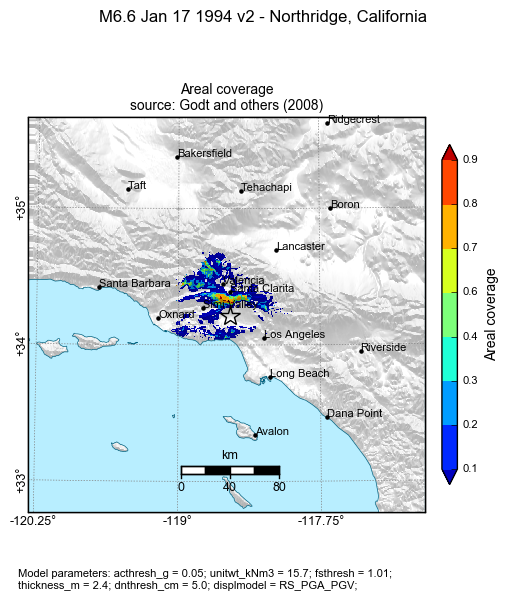

In [3]:
# read in the model config file and correct filepaths to absolute filepaths
configG = ConfigObj(configfileG)
configG = correct_config_filepaths(datadir, configG)

# run the model without saving the input layers
maplayers_godt = godt2008(shakefile, configG, saveinputs=False)

# read in mapping preferences from the config file specific to this model
plotorder, logscale, lims, colormaps, maskthreshes = parseConfigLayers(maplayers_godt, configG)

# read in general mapping preferences
mapconfig = ConfigObj(mapconfig)
kwargs = parseMapConfig(mapconfig, fileext=map_inputs)

# Make static plot of model output (to output figures to png or pdf, set savepng or savepdf to True)
temp = makemaps.modelMap(maplayers_godt, shakefile, lims=lims, maskthreshes=maskthreshes,
         logscale=logscale, maproads=False, mapcities=True, showplots=True, printparam=True,
         inventory_shapefile=None, scaletype='binned', savepdf=False, savepng=False,
         **kwargs)

### Now make interactive html plot of model
* Note that there is no colorbar - this is added to .html output as a .png file that floats over the image so it is not rendered in this notebook.
* You can plot the inventory over the interactive map by setting inventory_shapefile=inventory in interactiveMap. It is a large inventory so it makes everything slow, which is why it's not done here.
* This outputs an html file that can be opened in any internet browser

In [9]:
# Prepare to display folium plot inline in notebook
from IPython.display import display

# Now make an interactive map
map1 = makemaps.interactiveMap(maplayers_godt, plotorder=plotorder, shakefile=shakefile, maskthreshes=maskthreshes,
                               colormaps=colormaps, lims=lims)
display(map1)

No output location given, using current directory for outputs



## Now we'll run one of the logistic models

In [ ]:
configN = ConfigObj(configfileN)
configN = correct_config_filepaths(datadir, configN)

# This time we'll save the inputs and plot those as well, saveinputs=True
# We'll also zoom in on the action
bounds = 'zoom'
zthresh = 0.1 # value used to determine the zoom bounds, this value is assumed to be the minimum value of interest

# This model is set up differently than the previous one, you first define the class, then calculate the model
lmn = LogisticModel(shakefile, configN, saveinputs=True)

maplayers_nowicki = lmn.calculate()

# Make static plot of model output (to output figures to png or pdf, set savepng or savepdf to True)
plotorder, logscale, lims, colormaps, maskthreshes = parseConfigLayers(maplayers_nowicki, configN)

# uses mapping preferences from earlier cell (**kwargs)
temp = makemaps.modelMap(maplayers_nowicki, shakefile, lims=lims, maskthreshes=maskthreshes,
         logscale=logscale, maproads=False, mapcities=True, showplots=True, printparam=True,
         inventory_shapefile=None, scaletype='binned', savepdf=False, savepng=False, boundaries=bounds,
         zthresh=zthresh, colormaps=colormaps, **kwargs)